In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pickle

In [2]:
def rk4(f,y0,dt,n,gamma):
  t = np.linspace(0, n * dt, n + 1)
  y = np.zeros((n+1, len(y0)))
  y[0] = y0
  for i in range(n):
    k1 = dt * f(t[i], y[i],gamma)
    k2 = dt * f(t[i] + 0.5 * dt, y[i] + 0.5 * k1,gamma)
    k3 = dt * f(t[i] + 0.5 * dt, y[i] + 0.5 * k2,gamma)
    k4 = dt * f(t[i] + dt, y[i] + k3,gamma)
    y[i + 1] = y[i] + (1/6) * (k1 + 2 * k2 + 2 * k3 + k4)
  return y,t

In [3]:
#Dispersion relation
R_dim = 30e3
R_nondim = R_dim/300e3
beta_dim = 2e-12
beta_nondim = beta_dim * 86400 * 300e3

print(R_nondim,beta_nondim)
#Fourier harmonics
S = 10 #spectral radius
N = 41

def omega(k,l):
    return -beta_nondim * k / (k**2 + l**2 + R_nondim**-2)

P = 5 #radius of peak
H = 0.008 #height of peak (max amplitude)

def A(k,l):
  return H * np.exp(-0.5*(k**2+l**2-P**2)**2/(2*P**2))

0.1 0.05184


In [4]:
k,l = np.linspace(-S,S,N),np.linspace(-S,S,N)
K,L = np.meshgrid(k,l)
phi = np.random.uniform(0,2*np.pi,size=(N,N))
omega_vals = omega(K,L)

def modulo_grid(x, y):
  x_mod = np.mod(x + np.pi, 2 * np.pi) - np.pi
  y_mod = np.mod(y + np.pi, 2 * np.pi) - np.pi
  return x_mod, y_mod


def f(t,y,gamma = 0.01):
  x_mod,y_mod = modulo_grid(y[0],y[1])
  C = y[2]

  #1st derivatives
  dpsi_dx = np.real(np.sum(1j*K*A(K,L)*np.exp(1j*(K*x_mod + L*y_mod - omega_vals*t + phi))))
  dpsi_dy = np.real(np.sum(1j*L*A(K,L)*np.exp(1j*(K*x_mod + L*y_mod - omega_vals*t + phi))))
  dphi_dx = dpsi_dx
  dphi_dy = dpsi_dy

  #2nd derivatives
  d2phi_dx2 = np.real(np.sum(-K**2*A(K,L)*np.exp(1j*(K*x_mod + L*y_mod - omega_vals*t + phi))))
  d2phi_dy2 = np.real(np.sum(-L**2*A(K,L)*np.exp(1j*(K*x_mod + L*y_mod - omega_vals*t + phi))))

  u = gamma * dphi_dx - (1-gamma) * dpsi_dy
  v = gamma * dphi_dy + (1-gamma) * dpsi_dx
  DC = -C * (d2phi_dx2 + d2phi_dy2)
  return np.array([u,v,DC])

In [5]:
f(30,[2,3,0.2],0.01)

array([-0.05879887,  0.05641534, -0.49602569])

In [6]:
#Single trajectory
y0 = np.array([2,1,0.1])
dt = 1/24 #time step 1 hour
n = 10000
gamma = 0.01
y,t = rk4(f,y0,dt,n,gamma)

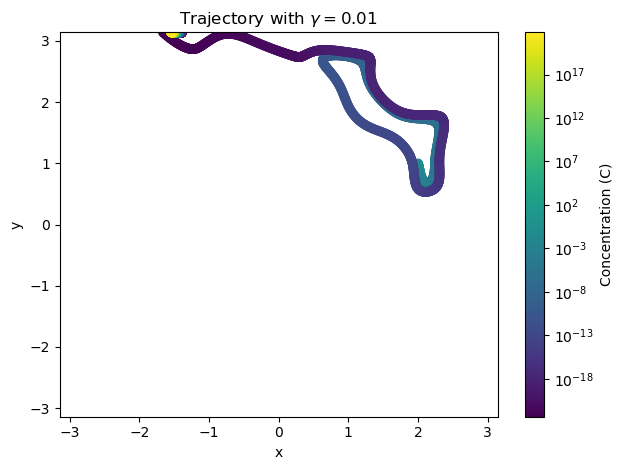

In [7]:
mask = np.isinf(y[:,2])
y[mask,2] = 0

from matplotlib.colors import LogNorm
fig, ax = plt.subplots()

line = ax.scatter(y[:,0],y[:,1], c=y[:,2], cmap='viridis', norm = LogNorm())
cbar = plt.colorbar(line)
cbar.set_label('Concentration (C)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-np.pi, np.pi)
gamma_label = r'$\gamma = {}$'.format(gamma)
plt.title('Trajectory with ' + gamma_label)

plt.tight_layout()
plt.show()

In [8]:
#Single trajectory
gamma = 1
t_span = (0,1000)
y0 = [1,1,1] #position and concentration
sol = solve_ivp(f,t_span,y0,args=(gamma,))

path = sol.y

divergence = np.empty(len(sol.t))
for i,t in enumerate(sol.t):
  d2phi_dx2 = np.real(np.sum(-K**2*A(K,L)*np.exp(1j*(K*sol.y[0,i] + L*sol.y[1,i] - omega_vals*t + phi))))
  d2phi_dy2 = np.real(np.sum(-L**2*A(K,L)*np.exp(1j*(K*sol.y[0,i] + L*sol.y[1,i] - omega_vals*t + phi))))
  divergence[i] = d2phi_dx2 + d2phi_dy2

-2.4981549667939142

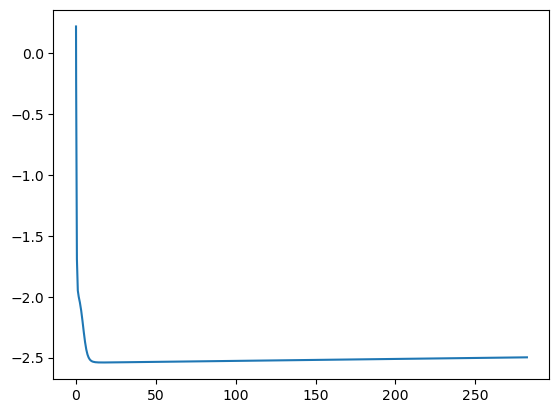

In [9]:
plt.plot(sol.t,divergence)
divergence.mean()

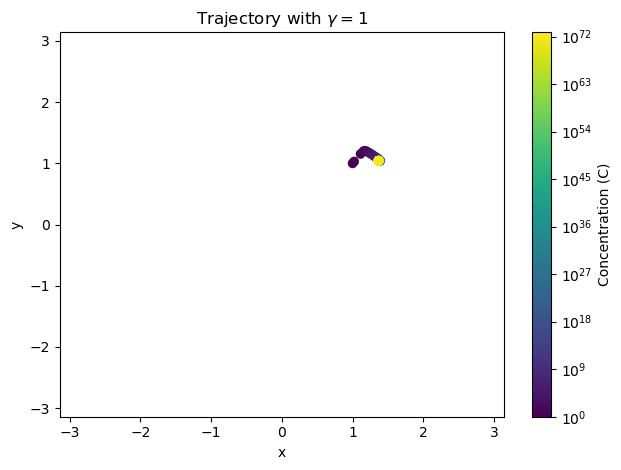

In [10]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots()

line = ax.scatter(sol.y[0,:100],sol.y[1,:100], c=sol.y[2,:100], cmap='viridis', norm = LogNorm())
cbar = plt.colorbar(line)
cbar.set_label('Concentration (C)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-np.pi, np.pi)
gamma_label = r'$\gamma = {}$'.format(gamma)
plt.title('Trajectory with ' + gamma_label)

plt.tight_layout()
plt.show()

In [11]:
path[0,-1],path[1,-1],path[0,100],path[1,100]

(1.277207894557817, 1.0399917957328724, 1.364418797418645, 1.0418376608063262)

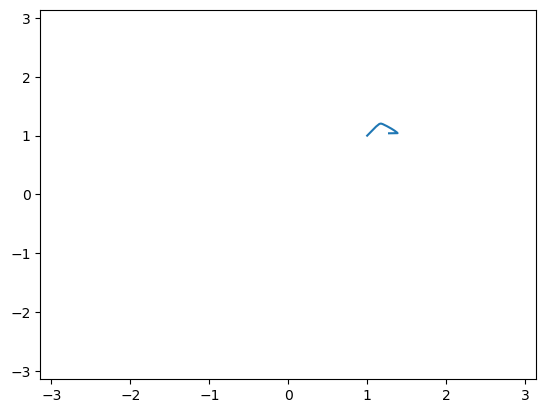

In [12]:
plt.plot(path[0],path[1])
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)

plt.show()

In [13]:
t_span = (0,5000)
#t_eval = np.linspace(t_span[0], t_span[1], num=500)

#Randomly select initial points
np.random.seed(42)
num_points = 100
x_coords = np.random.uniform(-np.pi, np.pi, num_points)
y_coords = np.random.uniform(-np.pi, np.pi, num_points)
C = np.ones(num_points)
initial_conditions = np.column_stack((x_coords, y_coords,C))

solutions = []


for y0 in initial_conditions:
  sol = solve_ivp(f,t_span,y0)
  solutions.append(sol)

C:\Users\William\AppData\Local\Temp\ipykernel_11912\648075391.py:28: RuntimeWarning: overflow encountered in double_scalars
  DC = -C * (d2phi_dx2 + d2phi_dy2)


In [14]:
with open('solutions.pickle', 'wb') as file:
    pickle.dump(solutions, file)

with open('solutions.pickle', 'rb') as file:
    loaded_solutions = pickle.load(file)

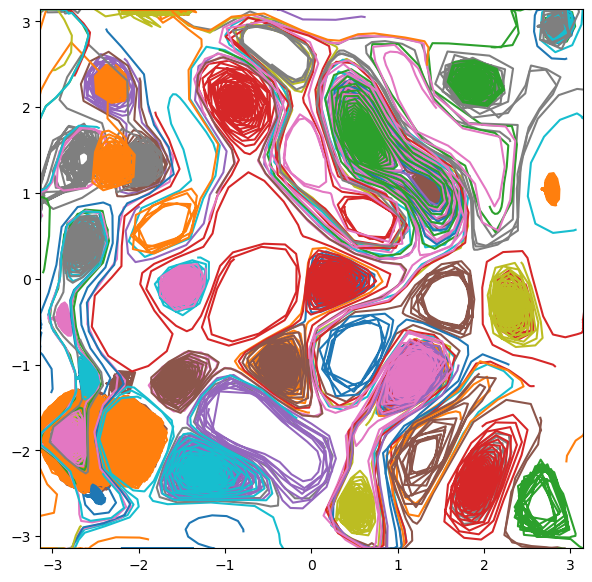

In [15]:
#Plot the trajectories (without concentration colour)

plt.figure(figsize=(7, 7))
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)

for sol in solutions:
  plt.plot(sol.y[0],sol.y[1])

plt.show()



AttributeError: 'AxesSubplot' object has no attribute 'xlim'

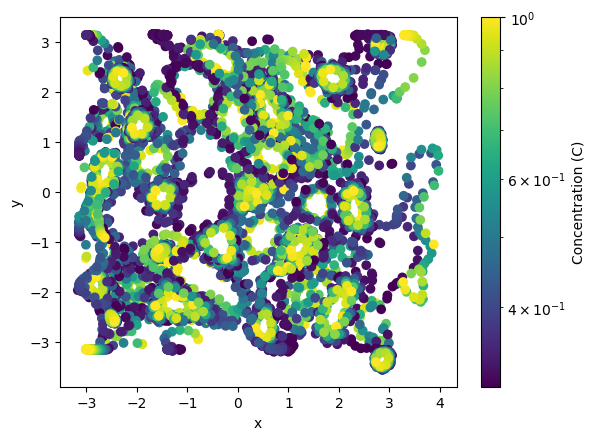

In [16]:
#Plot with colour
fig, ax = plt.subplots()
for sol in solutions:
  line = ax.scatter(sol.y[0,:50],sol.y[1,:50], c=sol.y[2,:50], cmap='viridis',norm = LogNorm())


cbar = plt.colorbar(line)
cbar.set_label('Concentration (C)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.xlim(-np.pi, np.pi)
ax.ylim(-np.pi, np.pi)
plt.show()